In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import mlflow
from mrmr import mrmr_classif
import os
import matplotlib.pyplot as plt


In [19]:
"""
Descarga de Archivos desde Google Drive sin Autenticación

Este script permite descargar archivos específicos desde Google Drive directamente a una ubicación local,
utilizando el ID de Google Drive del archivo (el archivo debe ser accesible para cualquier persona que tenga la URL).

El script procesa un archivo de texto ('archivos_info.txt') que contiene las IDs de Google Drive de los archivos,
los nombres con los que se desean guardar localmente, y las rutas locales de almacenamiento, todo separado por comas.

Formato esperado de 'archivos_info.txt':
ID_de_Google_Drive,Nombre_Archivo_Local,Ruta_Local

Ejemplo:
1hGvKmNAkK...,mi_archivo.txt,./descargas

Requisitos:
- Módulo 'requests' instalado en el entorno Python donde se ejecute este script.



"""

import requests
import os


def descargar_archivo_directo(id_archivo, directorio_destino, archivo_destino):
    """
    Descarga un archivo directamente desde Google Drive y lo guarda localmente.

    Parámetros:
    - id_archivo (str): ID del archivo en Google Drive.
    - directorio_destino (str): Ruta del directorio local donde se guardará el archivo.
    - archivo_destino (str): Nombre deseado para el archivo en local

    Devuelve:
    - archivo_destino (str): Nombre del archivo guardado.
    - ruta_completa (str): Ruta completa del archivo guardado.
    """
    # Construye la URL de descarga directa utilizando el ID del archivo
    url = f"https://drive.google.com/uc?export=download&id={id_archivo}"

    # Realiza la petición HTTP GET para descargar el archivo
    respuesta = requests.get(url, allow_redirects=True)

    # Comprueba que el directorio destino existe, si no, lo crea
    os.makedirs(directorio_destino, exist_ok=True)

    # Construye la ruta completa donde se guardará el archivo en local
    ruta_completa = os.path.join(directorio_destino, archivo_destino)

    # Guarda el contenido del archivo descargado en local
    with open(ruta_completa, 'wb') as archivo:
        archivo.write(respuesta.content)


    return archivo_destino, ruta_completa


def procesar_archivo_info(ruta_archivo_info):
    """
    Procesa un archivo de texto que contiene información sobre los archivos a descargar.

    Parámetros:
    - ruta_archivo_info (str): Ruta del archivo de texto que contiene los IDs de Google Drive,
                               los nombres de los archivos locales y las rutas locales.

    Devuelve:
    - Una lista de tuplas con el ID de Google Drive, el nombre local del archivo, y la ruta local.
    """
    archivos_info = []
    with open(ruta_archivo_info, 'r') as archivo:
        for linea in archivo:
            id_archivo, nombre_archivo, directorio_destino = linea.strip().split(',')
            archivos_info.append((id_archivo, nombre_archivo, directorio_destino))
    return archivos_info


In [20]:
# Ruta al archivo que contiene la información de los archivos a descargar
ruta_archivo_info = "..\info_archivos_GDrive_solo_entr.txt"

# Obtenemos la lista con la info de los archivos del fichero
archivos_a_descargar = procesar_archivo_info(ruta_archivo_info)

# Descargamos cada archivo de la lista
for id_archivo, nombre_archivo, directorio_destino in archivos_a_descargar:
    nombre_archivo_descargado, ruta_archivo_guardado = descargar_archivo_directo(id_archivo, directorio_destino, nombre_archivo)
    print(f"Archivo {nombre_archivo_descargado} guardado en: {ruta_archivo_guardado}")

Archivo datos_preparados_solo_entr.parquet guardado en: ../Downloads\datos_preparados_solo_entr.parquet


In [21]:
df = pd.read_parquet(ruta_archivo_guardado, engine='pyarrow')
df.describe()

,Mins,Goals,Assists,Yel,Red,SpG,PS%,AerialsWon,MotM,Tackles,...,nationality_The Gambia,nationality_Türkiye,nationality_Ukraine,nationality_United States,nationality_Uruguay,nationality_Venezuela,nationality_Wales,nationality_Zambia,nationality_Zimbabwe,marketValue
count,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,...,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2251.000000,2.251000e+03
mean,1271.695691,1.564638,1.063527,3.069303,0.168814,0.629276,76.128387,0.946246,0.622834,0.882719,...,0.000444,0.002665,0.001333,0.003554,0.028432,0.003998,0.000888,0.000444,0.000444,8.160329e+06
std,969.241058,2.906800,1.737932,2.958017,0.430942,0.604061,13.308598,0.962542,1.244505,0.693640,...,0.021077,0.051571,0.036490,0.059522,0.166240,0.063119,0.029801,0.021077,0.021077,1.188624e+07
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000e+04
25%,360.500000,0.000000,0.000000,1.000000,0.000000,0.200000,70.950000,0.300000,0.000000,0.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000e+06
50%,1157.000000,0.000000,0.000000,2.000000,0.000000,0.500000,78.300000,0.700000,0.000000,0.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+06
75%,2040.500000,2.000000,2.000000,5.000000,0.000000,0.900000,84.200000,1.300000,1.000000,1.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.500000e+06
max,3420.000000,27.000000,16.000000,15.000000,3.000000,4.500000,100.000000,8.700000,13.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.500000e+07


In [22]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Partición de datos
RANDOM_STATE = 83
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [23]:
# Establecer la URI de la base de datos SQLite y configuración de MLflow
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("regresion_lineal")

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1713193978222, experiment_id='3', last_update_time=1713193978222, lifecycle_stage='active', name='regresion_lineal', tags={}>

# Selección con MRMR

100%|██████████| 1/1 [00:00<00:00, 66.68it/s]


Iteration 1 - Train MAE: 3005460.6803, Test MAE: 3034502.7757


100%|██████████| 2/2 [00:00<00:00, 33.41it/s]


Iteration 2 - Train MAE: 3006971.6013, Test MAE: 3032838.2637


100%|██████████| 3/3 [00:00<00:00, 51.64it/s]


Iteration 3 - Train MAE: 3005562.3272, Test MAE: 3033916.9521


100%|██████████| 4/4 [00:00<00:00, 41.32it/s]


Iteration 4 - Train MAE: 3005174.6396, Test MAE: 3033316.4822


100%|██████████| 5/5 [00:00<00:00, 42.10it/s]


Iteration 5 - Train MAE: 3006192.9105, Test MAE: 3025738.6261


100%|██████████| 6/6 [00:00<00:00, 40.46it/s]


Iteration 6 - Train MAE: 3004677.2483, Test MAE: 3043658.0273


100%|██████████| 7/7 [00:00<00:00, 39.28it/s]


Iteration 7 - Train MAE: 3004383.5081, Test MAE: 3043961.7150


100%|██████████| 8/8 [00:00<00:00, 40.68it/s]


Iteration 8 - Train MAE: 3004094.6897, Test MAE: 3042912.5372


100%|██████████| 9/9 [00:00<00:00, 42.06it/s]


Iteration 9 - Train MAE: 3004844.7819, Test MAE: 3043823.9397


100%|██████████| 10/10 [00:00<00:00, 33.62it/s]


Iteration 10 - Train MAE: 3001665.7752, Test MAE: 3036329.1402


100%|██████████| 11/11 [00:00<00:00, 34.98it/s]


Iteration 11 - Train MAE: 3002239.4084, Test MAE: 3039270.7211


100%|██████████| 12/12 [00:00<00:00, 34.45it/s]


Iteration 12 - Train MAE: 2997983.9458, Test MAE: 3037997.7062


100%|██████████| 13/13 [00:00<00:00, 33.27it/s]


Iteration 13 - Train MAE: 2998131.9306, Test MAE: 3037355.2049


100%|██████████| 14/14 [00:00<00:00, 34.39it/s]


Iteration 14 - Train MAE: 2997982.8886, Test MAE: 3036747.3833


100%|██████████| 15/15 [00:00<00:00, 33.73it/s]


Iteration 15 - Train MAE: 2995510.3296, Test MAE: 3029318.0088


100%|██████████| 16/16 [00:00<00:00, 34.31it/s]


Iteration 16 - Train MAE: 2995117.5063, Test MAE: 3032067.7841


100%|██████████| 17/17 [00:00<00:00, 35.09it/s]


Iteration 17 - Train MAE: 2927492.9041, Test MAE: 2956767.2838


100%|██████████| 18/18 [00:00<00:00, 35.39it/s]


Iteration 18 - Train MAE: 2927388.9371, Test MAE: 2956327.2488


100%|██████████| 19/19 [00:00<00:00, 35.29it/s]


Iteration 19 - Train MAE: 2927020.6005, Test MAE: 2956307.7117


100%|██████████| 20/20 [00:00<00:00, 35.47it/s]


Iteration 20 - Train MAE: 2927606.2654, Test MAE: 2956744.2067


100%|██████████| 21/21 [00:00<00:00, 35.65it/s]


Iteration 21 - Train MAE: 2931142.9022, Test MAE: 2961178.8461


100%|██████████| 22/22 [00:00<00:00, 35.33it/s]


Iteration 22 - Train MAE: 2927959.0483, Test MAE: 2967838.1242


100%|██████████| 23/23 [00:00<00:00, 36.86it/s]


Iteration 23 - Train MAE: 2928155.3420, Test MAE: 2968024.6816


100%|██████████| 24/24 [00:00<00:00, 36.51it/s]


Iteration 24 - Train MAE: 2928581.4276, Test MAE: 2966118.0911


100%|██████████| 25/25 [00:00<00:00, 34.62it/s]


Iteration 25 - Train MAE: 2883707.1969, Test MAE: 2968672.7058


100%|██████████| 26/26 [00:00<00:00, 37.28it/s]


Iteration 26 - Train MAE: 2884670.2817, Test MAE: 2968680.6075


100%|██████████| 27/27 [00:00<00:00, 36.19it/s]


Iteration 27 - Train MAE: 2889827.8871, Test MAE: 2975995.0292


100%|██████████| 28/28 [00:00<00:00, 36.72it/s]


Iteration 28 - Train MAE: 2888033.8138, Test MAE: 2975075.9517


100%|██████████| 29/29 [00:00<00:00, 34.66it/s]


Iteration 29 - Train MAE: 2887298.0318, Test MAE: 2978007.7010


100%|██████████| 30/30 [00:00<00:00, 35.06it/s]


Iteration 30 - Train MAE: 2886698.5130, Test MAE: 2978237.4233


100%|██████████| 31/31 [00:01<00:00, 27.37it/s]


Iteration 31 - Train MAE: 2886375.6032, Test MAE: 2976011.6260


100%|██████████| 32/32 [00:01<00:00, 31.62it/s]


Iteration 32 - Train MAE: 2884835.7100, Test MAE: 2975336.9349


100%|██████████| 33/33 [00:01<00:00, 29.34it/s]


Iteration 33 - Train MAE: 2883542.9789, Test MAE: 2973840.1030


100%|██████████| 34/34 [00:01<00:00, 30.39it/s]


Iteration 34 - Train MAE: 2883510.5453, Test MAE: 2973940.0339


100%|██████████| 35/35 [00:01<00:00, 32.93it/s]


Iteration 35 - Train MAE: 2882651.3510, Test MAE: 2974420.1951


100%|██████████| 36/36 [00:01<00:00, 25.98it/s]


Iteration 36 - Train MAE: 2882666.6282, Test MAE: 2974431.3468


100%|██████████| 37/37 [00:01<00:00, 26.51it/s]


Iteration 37 - Train MAE: 2853282.7265, Test MAE: 2996687.3831


100%|██████████| 38/38 [00:01<00:00, 28.32it/s]


Iteration 38 - Train MAE: 2853506.4375, Test MAE: 2999500.0144


100%|██████████| 39/39 [00:01<00:00, 25.29it/s]


Iteration 39 - Train MAE: 2840299.1946, Test MAE: 3014452.8231


100%|██████████| 40/40 [00:01<00:00, 32.06it/s]


Iteration 40 - Train MAE: 2841803.0486, Test MAE: 3014038.1707


100%|██████████| 41/41 [00:01<00:00, 37.57it/s]


Iteration 41 - Train MAE: 2841814.5201, Test MAE: 3013937.3570


100%|██████████| 42/42 [00:01<00:00, 26.38it/s]


Iteration 42 - Train MAE: 2866383.6496, Test MAE: 2980171.4230


100%|██████████| 43/43 [00:01<00:00, 34.40it/s]


Iteration 43 - Train MAE: 2866914.5337, Test MAE: 2981386.7829


100%|██████████| 44/44 [00:02<00:00, 19.45it/s]


Iteration 44 - Train MAE: 2867753.0882, Test MAE: 2981747.1574


100%|██████████| 45/45 [00:01<00:00, 33.09it/s]


Iteration 45 - Train MAE: 2867825.0968, Test MAE: 2981373.2635


100%|██████████| 46/46 [00:01<00:00, 34.95it/s]


Iteration 46 - Train MAE: 2867926.5032, Test MAE: 2981498.7694


100%|██████████| 47/47 [00:01<00:00, 35.09it/s]


Iteration 47 - Train MAE: 2871712.4932, Test MAE: 3008274.8160


100%|██████████| 48/48 [00:01<00:00, 35.84it/s]


Iteration 48 - Train MAE: 2872968.0802, Test MAE: 3010831.3691


100%|██████████| 49/49 [00:01<00:00, 34.76it/s]


Iteration 49 - Train MAE: 2873115.1890, Test MAE: 3011571.5465


100%|██████████| 50/50 [00:01<00:00, 34.99it/s]


Iteration 50 - Train MAE: 2870142.8972, Test MAE: 3004251.7869


100%|██████████| 51/51 [00:01<00:00, 37.36it/s]


Iteration 51 - Train MAE: 2870194.2409, Test MAE: 3004715.9491


100%|██████████| 52/52 [00:01<00:00, 37.79it/s]


Iteration 52 - Train MAE: 2869842.5786, Test MAE: 3003955.3469


100%|██████████| 53/53 [00:01<00:00, 39.47it/s]


Iteration 53 - Train MAE: 2861937.8290, Test MAE: 3002964.6710


100%|██████████| 54/54 [00:01<00:00, 33.75it/s]


Iteration 54 - Train MAE: 2861630.5782, Test MAE: 3002576.6253


100%|██████████| 55/55 [00:01<00:00, 37.77it/s]


Iteration 55 - Train MAE: 2862560.1240, Test MAE: 3002420.6308


100%|██████████| 56/56 [00:01<00:00, 32.97it/s]


Iteration 56 - Train MAE: 2863280.1507, Test MAE: 3004256.5195


100%|██████████| 57/57 [00:01<00:00, 37.91it/s]


Iteration 57 - Train MAE: 2860578.2075, Test MAE: 3001333.3934


100%|██████████| 58/58 [00:01<00:00, 37.89it/s]


Iteration 58 - Train MAE: 2809723.6763, Test MAE: 2952179.6766


100%|██████████| 59/59 [00:01<00:00, 37.47it/s]


Iteration 59 - Train MAE: 2814322.1397, Test MAE: 2958423.1360


100%|██████████| 60/60 [00:01<00:00, 35.69it/s]


Iteration 60 - Train MAE: 2819391.9834, Test MAE: 2948715.5570


100%|██████████| 61/61 [00:01<00:00, 41.78it/s]


Iteration 61 - Train MAE: 2818897.9805, Test MAE: 2948965.7046


100%|██████████| 62/62 [00:01<00:00, 37.93it/s]


Iteration 62 - Train MAE: 2814027.8161, Test MAE: 2929905.5460


100%|██████████| 63/63 [00:01<00:00, 42.03it/s]


Iteration 63 - Train MAE: 2814035.6825, Test MAE: 2931223.7339


100%|██████████| 64/64 [00:01<00:00, 42.78it/s]


Iteration 64 - Train MAE: 2823083.9153, Test MAE: 2945403.4744


100%|██████████| 65/65 [00:01<00:00, 43.51it/s]


Iteration 65 - Train MAE: 2826364.2115, Test MAE: 2952056.6748


100%|██████████| 66/66 [00:01<00:00, 41.48it/s]


Iteration 66 - Train MAE: 2829713.4144, Test MAE: 2974220.7666


100%|██████████| 67/67 [00:01<00:00, 41.45it/s]


Iteration 67 - Train MAE: 2819161.3335, Test MAE: 2911454.9184


100%|██████████| 68/68 [00:01<00:00, 42.78it/s]


Iteration 68 - Train MAE: 2813399.4907, Test MAE: 2914175.4689


100%|██████████| 69/69 [00:01<00:00, 41.38it/s]


Iteration 69 - Train MAE: 2812544.9729, Test MAE: 2912145.8925


100%|██████████| 70/70 [00:01<00:00, 42.82it/s]


Iteration 70 - Train MAE: 2811541.9573, Test MAE: 2907147.6289


100%|██████████| 71/71 [00:01<00:00, 40.24it/s]


Iteration 71 - Train MAE: 2808339.3233, Test MAE: 2907383.7577


100%|██████████| 72/72 [00:01<00:00, 46.20it/s]


Iteration 72 - Train MAE: 2807912.2890, Test MAE: 2908125.6983


100%|██████████| 73/73 [00:01<00:00, 47.06it/s]


Iteration 73 - Train MAE: 2812421.4548, Test MAE: 2907496.9338


100%|██████████| 74/74 [00:01<00:00, 46.55it/s]


Iteration 74 - Train MAE: 2793105.3967, Test MAE: 2888220.7186


100%|██████████| 75/75 [00:01<00:00, 46.92it/s]


Iteration 75 - Train MAE: 2793562.0275, Test MAE: 2890864.7739


100%|██████████| 76/76 [00:02<00:00, 28.32it/s]


Iteration 76 - Train MAE: 2790783.2800, Test MAE: 2883779.4275


100%|██████████| 77/77 [00:01<00:00, 46.19it/s]


Iteration 77 - Train MAE: 2789661.8401, Test MAE: 2886280.0420


100%|██████████| 78/78 [00:01<00:00, 48.81it/s]


Iteration 78 - Train MAE: 2788726.0677, Test MAE: 2888951.0040


100%|██████████| 79/79 [00:01<00:00, 47.98it/s]


Iteration 79 - Train MAE: 2783911.8259, Test MAE: 2881126.1956


100%|██████████| 80/80 [00:01<00:00, 46.14it/s]


Iteration 80 - Train MAE: 2782230.3021, Test MAE: 2885670.7328


100%|██████████| 81/81 [00:01<00:00, 45.75it/s]


Iteration 81 - Train MAE: 2783135.0438, Test MAE: 2889025.2274


100%|██████████| 82/82 [00:01<00:00, 41.07it/s]


Iteration 82 - Train MAE: 2779198.5543, Test MAE: 2886143.4021


100%|██████████| 83/83 [00:02<00:00, 40.75it/s]


Iteration 83 - Train MAE: 2779019.7935, Test MAE: 2886168.8280


100%|██████████| 84/84 [00:02<00:00, 39.86it/s]


Iteration 84 - Train MAE: 2779394.3161, Test MAE: 2886536.4493


100%|██████████| 85/85 [00:02<00:00, 40.94it/s]


Iteration 85 - Train MAE: 2779217.7023, Test MAE: 2886294.8471


100%|██████████| 86/86 [00:02<00:00, 39.13it/s]


Iteration 86 - Train MAE: 2779705.2463, Test MAE: 2881755.0068


100%|██████████| 87/87 [00:02<00:00, 37.90it/s]


Iteration 87 - Train MAE: 2779191.1542, Test MAE: 2881724.8722


100%|██████████| 88/88 [00:02<00:00, 39.20it/s]


Iteration 88 - Train MAE: 2775922.5641, Test MAE: 2880595.5378


100%|██████████| 89/89 [00:02<00:00, 39.65it/s]


Iteration 89 - Train MAE: 2776462.4025, Test MAE: 2883274.2324


100%|██████████| 90/90 [00:02<00:00, 44.52it/s]


Iteration 90 - Train MAE: 2780392.6875, Test MAE: 2880159.9917


100%|██████████| 91/91 [00:01<00:00, 47.18it/s]


Iteration 91 - Train MAE: 2780144.4225, Test MAE: 2873758.5120


100%|██████████| 92/92 [00:01<00:00, 46.46it/s]


Iteration 92 - Train MAE: 2770637.3408, Test MAE: 2876669.2055


100%|██████████| 93/93 [00:02<00:00, 40.84it/s]


Iteration 93 - Train MAE: 2771091.9880, Test MAE: 2877239.3157


100%|██████████| 94/94 [00:02<00:00, 40.66it/s]


Iteration 94 - Train MAE: 2771373.7812, Test MAE: 2880146.0110


100%|██████████| 95/95 [00:02<00:00, 40.27it/s]


Iteration 95 - Train MAE: 2770085.9480, Test MAE: 2881040.9807


100%|██████████| 96/96 [00:02<00:00, 43.38it/s]


Iteration 96 - Train MAE: 2769084.2394, Test MAE: 2881357.8202


100%|██████████| 97/97 [00:02<00:00, 47.65it/s]


Iteration 97 - Train MAE: 2769456.0921, Test MAE: 2881315.9117


100%|██████████| 98/98 [00:03<00:00, 32.25it/s]


Iteration 98 - Train MAE: 2768988.4839, Test MAE: 2880991.6388


100%|██████████| 99/99 [00:02<00:00, 40.74it/s]


Iteration 99 - Train MAE: 2769538.3623, Test MAE: 2879249.2767


100%|██████████| 100/100 [00:02<00:00, 42.40it/s]


Iteration 100 - Train MAE: 2769537.8373, Test MAE: 2879026.5043


100%|██████████| 101/101 [00:02<00:00, 40.15it/s]


Iteration 101 - Train MAE: 2743181.1344, Test MAE: 2902131.3602


100%|██████████| 102/102 [00:02<00:00, 45.94it/s]


Iteration 102 - Train MAE: 2742404.6837, Test MAE: 2899381.8741


100%|██████████| 103/103 [00:02<00:00, 44.81it/s]


Iteration 103 - Train MAE: 2742552.5523, Test MAE: 2899342.3883


100%|██████████| 104/104 [00:02<00:00, 47.44it/s]


Iteration 104 - Train MAE: 2738681.8522, Test MAE: 2906418.7498


100%|██████████| 105/105 [00:02<00:00, 45.46it/s]


Iteration 105 - Train MAE: 2736474.4650, Test MAE: 2912559.0042


100%|██████████| 106/106 [00:02<00:00, 44.90it/s]


Iteration 106 - Train MAE: 2737101.1043, Test MAE: 2920660.9348


100%|██████████| 107/107 [00:02<00:00, 42.06it/s]


Iteration 107 - Train MAE: 2737052.5713, Test MAE: 2924358.9437


100%|██████████| 108/108 [00:02<00:00, 40.01it/s]


Iteration 108 - Train MAE: 2744297.1782, Test MAE: 2908413.1762


100%|██████████| 109/109 [00:02<00:00, 40.48it/s]


Iteration 109 - Train MAE: 2744850.9780, Test MAE: 2912658.4673


100%|██████████| 110/110 [00:02<00:00, 38.04it/s]


Iteration 110 - Train MAE: 2743435.3748, Test MAE: 2918928.3570


100%|██████████| 111/111 [00:02<00:00, 42.18it/s]


Iteration 111 - Train MAE: 2743553.1195, Test MAE: 2919857.4451


100%|██████████| 112/112 [00:02<00:00, 44.65it/s]


Iteration 112 - Train MAE: 2741168.7914, Test MAE: 2918627.1059


100%|██████████| 113/113 [00:02<00:00, 45.17it/s]


Iteration 113 - Train MAE: 2740275.6441, Test MAE: 2917626.4656


100%|██████████| 114/114 [00:02<00:00, 44.43it/s]


Iteration 114 - Train MAE: 2741486.8834, Test MAE: 2918832.1974


100%|██████████| 115/115 [00:02<00:00, 45.26it/s]


Iteration 115 - Train MAE: 2742945.5665, Test MAE: 2925640.7808


100%|██████████| 116/116 [00:02<00:00, 45.24it/s]


Iteration 116 - Train MAE: 2742939.4362, Test MAE: 2925527.8113


100%|██████████| 117/117 [00:03<00:00, 37.81it/s]


Iteration 117 - Train MAE: 2739820.2884, Test MAE: 2929263.0756


100%|██████████| 118/118 [00:02<00:00, 46.86it/s]


Iteration 118 - Train MAE: 2740259.3057, Test MAE: 2925171.8868


100%|██████████| 119/119 [00:03<00:00, 38.34it/s]


Iteration 119 - Train MAE: 2740280.8302, Test MAE: 2925501.6031


100%|██████████| 120/120 [00:02<00:00, 41.39it/s]


Iteration 120 - Train MAE: 2739168.4521, Test MAE: 2922916.3014


100%|██████████| 121/121 [00:02<00:00, 45.71it/s]


Iteration 121 - Train MAE: 2735419.2678, Test MAE: 2934058.4342


100%|██████████| 122/122 [00:02<00:00, 44.08it/s]


Iteration 122 - Train MAE: 2734748.6066, Test MAE: 2934439.0083


100%|██████████| 123/123 [00:02<00:00, 46.53it/s]


Iteration 123 - Train MAE: 2734299.6891, Test MAE: 2937466.9632


100%|██████████| 124/124 [00:02<00:00, 42.51it/s]


Iteration 124 - Train MAE: 2733927.7322, Test MAE: 2937976.6869


100%|██████████| 125/125 [00:03<00:00, 37.57it/s]


Iteration 125 - Train MAE: 2736029.8247, Test MAE: 2945896.2449


100%|██████████| 126/126 [00:03<00:00, 40.88it/s]


Iteration 126 - Train MAE: 2736502.2570, Test MAE: 2960554.8609


100%|██████████| 127/127 [00:02<00:00, 44.50it/s]


Iteration 127 - Train MAE: 2734421.9093, Test MAE: 2961493.2432


100%|██████████| 128/128 [00:03<00:00, 42.28it/s]


Iteration 128 - Train MAE: 2732654.7122, Test MAE: 2961688.8016


100%|██████████| 129/129 [00:03<00:00, 42.43it/s]


Iteration 129 - Train MAE: 2731664.4097, Test MAE: 2966869.8956


100%|██████████| 130/130 [00:03<00:00, 39.97it/s]


Iteration 130 - Train MAE: 2731440.3359, Test MAE: 2966875.1352


100%|██████████| 131/131 [00:03<00:00, 39.37it/s]


Iteration 131 - Train MAE: 2731731.8317, Test MAE: 2966808.7907


100%|██████████| 132/132 [00:03<00:00, 35.62it/s]


Iteration 132 - Train MAE: 2730566.3822, Test MAE: 2977341.7994


100%|██████████| 133/133 [00:03<00:00, 36.30it/s]


Iteration 133 - Train MAE: 2730974.5220, Test MAE: 2977264.4007


100%|██████████| 134/134 [00:03<00:00, 40.81it/s]


Iteration 134 - Train MAE: 2731248.0650, Test MAE: 2981210.6207


100%|██████████| 135/135 [00:03<00:00, 34.88it/s]


Iteration 135 - Train MAE: 2731745.0994, Test MAE: 2973600.0798


100%|██████████| 136/136 [00:03<00:00, 42.72it/s]


Iteration 136 - Train MAE: 2731745.0993, Test MAE: 2973600.0784


100%|██████████| 137/137 [00:04<00:00, 33.11it/s]


Iteration 137 - Train MAE: 2732388.0244, Test MAE: 2974395.9853


100%|██████████| 138/138 [00:02<00:00, 51.44it/s]


Iteration 138 - Train MAE: 2733651.3033, Test MAE: 2975780.1739


100%|██████████| 139/139 [00:02<00:00, 52.52it/s]


Iteration 139 - Train MAE: 2742552.1773, Test MAE: 2978096.0291


100%|██████████| 140/140 [00:02<00:00, 50.45it/s]


Iteration 140 - Train MAE: 2742532.3689, Test MAE: 442804767.8781


100%|██████████| 141/141 [00:03<00:00, 42.04it/s]


Iteration 141 - Train MAE: 2738593.4496, Test MAE: 406275280.5022


100%|██████████| 142/142 [00:03<00:00, 35.82it/s]


Iteration 142 - Train MAE: 2738067.4885, Test MAE: 450983979.8358


100%|██████████| 143/143 [00:10<00:00, 13.79it/s]


Iteration 143 - Train MAE: 2737004.7403, Test MAE: 440010325.6062


100%|██████████| 144/144 [00:04<00:00, 31.09it/s]


Iteration 144 - Train MAE: 2739490.2673, Test MAE: 435109602.5503


100%|██████████| 145/145 [00:05<00:00, 28.12it/s]


Iteration 145 - Train MAE: 2739529.8302, Test MAE: 447083050.4814


100%|██████████| 146/146 [00:07<00:00, 19.61it/s]


Iteration 146 - Train MAE: 2739728.9496, Test MAE: 432623045.0300


100%|██████████| 147/147 [00:05<00:00, 27.01it/s]


Iteration 147 - Train MAE: 2739831.8987, Test MAE: 406951362.9915


100%|██████████| 147/147 [00:05<00:00, 27.33it/s]


Iteration 148 - Train MAE: 2739831.8987, Test MAE: 406951362.9915


100%|██████████| 147/147 [00:05<00:00, 24.79it/s]


Iteration 149 - Train MAE: 2739831.8987, Test MAE: 406951362.9915


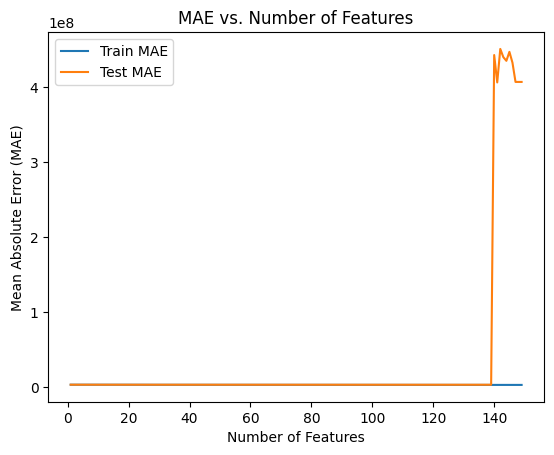

17 selected features: ['1_año_anterior', 'nationality_Denmark', 'nationality_Poland', 'nationality_Costa Rica', 'nationality_Mexico', 'nationality_Guinea', 'nationality_Zambia', 'nationality_Greece', 'nationality_Montenegro', 'nationality_Nigeria', 'nationality_Slovakia', 'Año_natural', 'nationality_England', 'nationality_Armenia', 'nationality_Norway', 'nationality_Dominican Republic', '2_año_anterior']
MAE with 17 features: 2956767.283751456


In [28]:

# Iniciar el registro de la ejecución en MLflow
with mlflow.start_run(run_name="MRMR Feature Selection"):

    # Definir la función para calcular el MRMR
    def calculate_mrmr_features(X, y, K):
        selected_features = mrmr_classif(X=X, y=y, K=K)
        return selected_features
    
    # Definir el rango de características que deseamos considerar
    feature_range = range(1, len(X.columns) + 1)
    
    # Listas para almacenar las métricas
    train_maes = []
    test_maes = []
    num_features_list = []
    
    # Variables para almacenar las 17 características y su MAE correspondiente
    selected_features_17 = None
    mae_17 = None
    
    # Iterar sobre todas las combinaciones de características
    for num_features in feature_range:
        # Calcular las características seleccionadas usando MRMR
        selected_features = calculate_mrmr_features(X_train, y_train, num_features)
        
        # Seleccionar las columnas correspondientes en X_train y X_test
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        # Entrenar el modelo de regresión lineal
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
    
        # Realizar predicciones en el conjunto de entrenamiento y de prueba
        y_pred_train = model.predict(X_train_selected)
        y_pred_test = model.predict(X_test_selected)
        
        # Calcular el error absoluto medio (MAE) para evaluar el modelo en ambos conjuntos
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Almacenar las métricas y el número de características
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        num_features_list.append(num_features)
        
        # Imprimir el MAE en cada iteración
        print(f"Iteration {num_features} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        
        # Registrar el MAE en MLflow
        mlflow.log_metric(f"train_mae_{num_features}", train_mae)
        mlflow.log_metric(f"test_mae_{num_features}", test_mae)
        
        # Verificar si se han encontrado las 17 características
        if num_features == 17:
            selected_features_17 = selected_features
            mae_17 = test_mae
    
    # Graficar los resultados
    plt.plot(num_features_list, train_maes, label='Train MAE')
    plt.plot(num_features_list, test_maes, label='Test MAE')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs. Number of Features')
    plt.legend()
    plt.show()
    
    # Imprimir las 17 características seleccionadas y su MAE correspondiente
    if selected_features_17 is not None:
        mlflow.log_param("selected_features_17", selected_features_17)
        print("17 selected features:", selected_features_17)
        print("MAE with 17 features:", mae_17)

Selected features with 9 features: ['Mins' 'Assists' 'MotM' 'Titularidades' 'Equipo_pos' '1_año_anterior'
 '2_año_anterior' '3_año_anterior' '4_año_anterior']
Selected features with 17 features: ['Mins' 'Goals' 'Assists' 'SpG' 'MotM' 'KeyP' 'OffDrb' 'AvgP'
 'Titularidades' 'Equipo_pos' '1_año_anterior' '2_año_anterior'
 '3_año_anterior' '4_año_anterior' '5_año_anterior' 'Equipo_FC Barcelona'
 'Equipo_Real Madrid']
Best number of features: 9


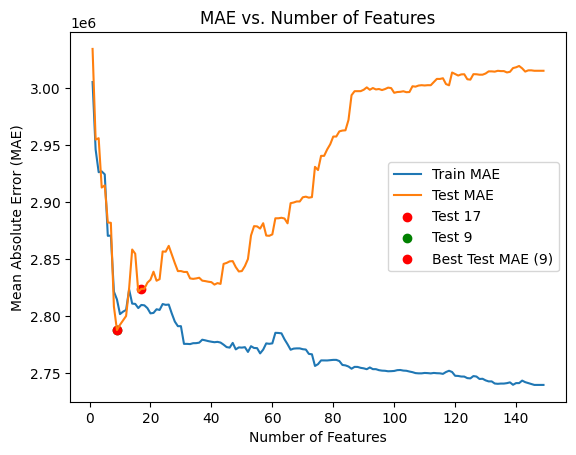

<Figure size 640x480 with 0 Axes>

In [29]:
import mlflow
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Iniciar el registro de la ejecución en MLflow
with mlflow.start_run(run_name="KBest Feature Selection"):

    # Definir el rango de características que deseamos considerar
    feature_range = range(1, len(X.columns) + 1)
    
    # Listas para almacenar las métricas
    train_maes = []
    test_maes = []
    
    # Iterar sobre todas las combinaciones de características
    for num_features in feature_range:
        # Seleccionar las mejores k características
        selector = SelectKBest(score_func=f_regression, k=num_features)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)
        
        # Entrenar un modelo de regresión lineal con las características seleccionadas
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
    
        # Realizar predicciones en el conjunto de prueba
        y_pred_train = model.predict(X_train_selected)
        y_pred_test = model.predict(X_test_selected)
        
        # Calcular el error absoluto medio (MAE) para evaluar el modelo en ambos conjuntos
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Almacenar las métricas
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        
        # Registrar los MAE en MLflow para cada iteración
        mlflow.log_metric(f"train_mae_{num_features}", train_mae)
        mlflow.log_metric(f"test_mae_{num_features}", test_mae)
        
        # Verificar si se han encontrado las 9 características
        if num_features == 9:
            # Obtener las características seleccionadas
            selected_features_9 = np.array(X.columns)[selector.get_support()]
            print(f"Selected features with {num_features} features:", selected_features_9)
            # Registrar las características seleccionadas en MLflow
            mlflow.log_param("selected_features_9", selected_features_9)
            
        # Verificar si se han encontrado las 17 características
        if num_features == 17:
            # Obtener las características seleccionadas
            selected_features_17 = np.array(X.columns)[selector.get_support()]
            print(f"Selected features with {num_features} features:", selected_features_17)
            # Registrar las características seleccionadas en MLflow
            mlflow.log_param("selected_features_17", selected_features_17)
    
    # Encontrar el número de características que produce el menor error absoluto medio en el conjunto de prueba
    best_num_features = feature_range[np.argmin(test_maes)]
    print("Best number of features:", best_num_features)
    
    # Graficar los resultados
    plt.plot(feature_range, train_maes, label='Train MAE')
    plt.plot(feature_range, test_maes, label='Test MAE')
    plt.scatter(17, test_maes[16], color='red', label='Test 17')
    plt.scatter(9, test_maes[8], color='green', label='Test 9')
    plt.scatter(best_num_features, min(test_maes), color='red', label='Best Test MAE (9)')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs. Number of Features')
    plt.legend()
    plt.show()
    image_path = "grafica_selección_variables.png"
    plt.savefig(image_path)
    mlflow.log_artifact(image_path, artifact_path="grafica seleccion variables")
